In [1]:
import sys
import os
import numpy as np
import re
# import psycopg2 as pg
# import pandas as pd
# import pandas.io.sql as psql
# import getpass
import matplotlib as mpl
import hashlib
import math
import collections
import functools
import datetime
from sklearn.externals import joblib
import pickle
import physt

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

# import event_processing_v3
# import event_processing_v4
# import postgresql_v3_event_storage
# import dataset_query_functions_v3

# import tool.acqconv
# from data_analysis_utils import *
from data_analysis_utils_trigger_rate import *
# import supervised_classification as supc 
# from utility_funtions import key_vals2val_keys

import event_reading


Welcome to JupyROOT 6.13/02


In [2]:
recreate_plots = True
recreate_pickles = False

In [3]:
files_dir_abspath = '/home/spbproc/SPBDATA_flight'
trg_files_dir_abspath_format = '/home/spbproc/SPBDATA_processed/{acq_dirname}/{acq_basename_no_ext}/l1_trigger_kenji/{l1trg_root_filename}'
flat_field_map_pathname = '/home/vrabel/EUSO-Balloon/vrabel/resources/inverse_flat_average_directions_4m_flipud.txt'

data_snippets_dir = 'trigger_rate_figures_sw_files'
os.makedirs(data_snippets_dir, exist_ok=True)
os.makedirs(os.path.join(data_snippets_dir, 'figures'), exist_ok=True)

In [4]:
def filter_func(f,d): 
    r = os.path.splitext(f)[1] == ".root" and "ACQUISITION" in os.path.basename(f) and re.search(r'SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170(42[4-9]|430|5\d+)$',d) is not None
    return r

processed_files = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(files_dir_abspath) for f in fn if filter_func(f,dp)])

In [44]:
def create_l1_trigger_data_pathname(file_pathname, files_dir_abspath, trg_files_dir_abspath_format, bgfactor, 
                                    flat_field_map_pathname=None, simple_prefix=False):
    bgfactor_in_file_name = bgfactor

    if not simple_prefix:
        acquisition_basename = os.path.basename(file_pathname)
        acquisition_basename_date_pos = acquisition_basename.index("ACQUISITION-")+12
        acquisition_date_str = acquisition_basename[acquisition_basename_date_pos:acquisition_basename_date_pos+23]

        if "sqz" in acquisition_basename:
            bgfactor_in_file_name = bgfactor * 128./25;
    else:
        acquisition_date_str = os.path.basename(file_pathname).rsplit('.',1)[0]
    
    flat_field_map_part = ''
    if flat_field_map_pathname is not None:
        flat_field_map_part = '_C_' + os.path.basename(flat_field_map_pathname).rsplit('.',1)[0]

    acq_dirname = os.path.dirname(os.path.relpath(file_pathname, files_dir_abspath))
    l1trg_root_filename = "trn_{}{}_bgf_{:.2f}.root".format(acquisition_date_str, flat_field_map_part, bgfactor_in_file_name)
        
    l1trg_root_pathname = \
        trg_files_dir_abspath_format.format(
            acq_dirname=acq_dirname, 
            l1trg_root_filename=l1trg_root_filename,
            acq_basename_no_ext=os.path.basename(file_pathname).rsplit('.',1)[0]
    )
    
    return l1trg_root_pathname

In [45]:
l1trg_bgf05_files = [create_l1_trigger_data_pathname(
    f, files_dir_abspath, trg_files_dir_abspath_format, 0.5, flat_field_map_pathname
) for f in processed_files]

In [19]:
processed_files_subset = processed_files[0:60]
l1trg_bgf05_files_subset = l1trg_bgf05_files[0:60]

In [20]:
print('Num processed files', len(processed_files_subset))

Num processed files 60


In [21]:
len(set([os.path.basename(p) for p in processed_files_subset]))

60

In [22]:
len(set([os.path.basename(p) for p in processed_files_subset if '20170424' not in p]))

48

In [23]:
processed_files_hash = hashlib.md5(pickle.dumps(processed_files_subset, protocol=0)).hexdigest()

In [24]:
processed_files_hash

'2f36cae80552871dfe66033e297b5ad2'

# Window size by file

In [29]:
def count_trigger_rate_per_file(acquisition_files_list, l1trg_files_list = None, 
                                data_snippets_dir=None, file_name_prefix='', 
                                trg_type='hw',
                                return_filenames=False, recreate_pickles=False, 
                                one_trg_per_packet=False, packet_size=128,
                                skip_missing_files=True
                               ):
    
    if trg_type == 'l1' and l1trg_files_list is None:
        raise RuntimeError('l1trg_files_list is None')
    
    one_trg_per_packet_str = '_one_trg_per_packet_{:d}'.format(packet_size) if one_trg_per_packet else ''
    
    processed_files_hash = hashlib.md5(pickle.dumps(acquisition_files_list, protocol=0)).hexdigest()
    
    trigger_num_per_file_list_pathname = None
    trigger_rate_per_file_list_pathname = None
    file_trigger_datetimes_list_pathname = None
    file_trigger_timedelta_list_pathname = None
    file_trigger_p_r_list_pathname = None
    file_indices_list_pathname = None
    
    if data_snippets_dir is not None:
        trigger_num_per_file_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}{}_trigger_num_per_file.pkl'.format(processed_files_hash, one_trg_per_packet_str))
        trigger_rate_per_file_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}{}_trigger_rate_per_file.pkl'.format(processed_files_hash, one_trg_per_packet_str))
        file_trigger_datetimes_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}{}_file_trigger_datetimes.pkl'.format(processed_files_hash, one_trg_per_packet_str))
        file_trigger_timedelta_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}{}_file_trigger_timedelta.pkl'.format(processed_files_hash, one_trg_per_packet_str))
        file_trigger_p_r_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}{}_file_trigger_p_r.pkl'.format(processed_files_hash, one_trg_per_packet_str))
        file_indices_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}{}_file_indices.pkl'.format(processed_files_hash, one_trg_per_packet_str))
    else:
        recreate_pickles = True
    
    # {allpackets | events}-experiment-mode-date-time-bunch.bunchTot--comment.dat,
    # TODO bunch
    
    filename_type_re = re.compile(r'(\d+)\.(\d+)-+(LONG|CHECK)(-sqz(-dis)?)?\.root$')
    
    filename_datetime_re = re.compile(r'(\d{4})(\d\d)(\d\d)-(\d\d)(\d\d)(\d\d)-(\d+)\.(\d+)-+(LONG|CHECK)(-sqz(-dis)?)?\.root$')
        
    trigger_num_per_file_list = []
    trigger_rate_per_file_list = []
    file_trigger_datetimes_list = []
    file_timedelta_list = []
    file_trigger_p_r_list = []
    file_indices_list = []

    if recreate_pickles or False in [os.path.exists(f) for f in (
            trigger_num_per_file_list_pathname, trigger_rate_per_file_list_pathname, 
            file_trigger_datetimes_list_pathname, file_trigger_timedelta_list_pathname, file_trigger_p_r_list_pathname, 
            file_indices_list_pathname)]:
    
#         print([os.path.exists(f) for f in (
#             trigger_num_per_file_list_pathname, trigger_rate_per_file_list_pathname, 
#             file_trigger_datetimes_list_pathname, file_trigger_timedelta_list_pathname, file_trigger_p_r_list_pathname, 
#             file_indices_list_pathname)])
    
#         return None, None, None, None, None, None
    
        last_p_r = None

        for j, infile in enumerate(sorted(acquisition_files_list)):

            print('{:d}/{:d} {}'.format(j+1, len(acquisition_files_list), infile))

            filename_type_m = filename_type_re.search(infile)
            if not filename_type_m:
                print(' > SKIPPING')
                continue
            
            if filename_type_m.group(3) == 'LONG':
                acq_timedelta = datetime.timedelta(seconds=120)
            elif filename_type_m.group(3) == 'CHECK':
                acq_timedelta = datetime.timedelta(seconds=40)

            bunch = int(filename_type_m.group(1))
            
            if bunch < 1:
                print(' > SKIPPING (bunch < 1)')
                continue
            
            #####
                
            file_last_frame_gtu_datetime = None
            file_first_frame_gtu_datetime = None
            
            file_last_frame_gtu_datetime__gps_datetime = None
            file_first_frame_gtu_datetime__gps_datetime = None
            
            file_last_frame_gps_datetime = None
            file_first_frame_gps_datetime = None                
                
            ####
                
            trigger_num_per_step = 0

            first_p_r = None
            last_p_r = None

            if trg_type == 'l1':
                acq_kwargs = dict(acquisition_pathname=infile, 
                                  kenji_l1_pathname=l1trg_files_list[j],
                                  load_pdm_event_summary=True, parse_pdm_event_summary=False
                                 )
                
                if not os.path.exists(l1trg_files_list[j]):
                    if not skip_missing_files:
                        raise RuntimeError('Missing l1trg file '+l1trg_files_list[j])
                    else:
                        print(' > SKIPPING (missing l1trg file {})'.format(l1trg_files_list[j]))
                        continue
            else:
                acq_kwargs = dict(acquisition_pathname=infile,
                                  kenji_l1_pathname=None,
                                  load_pdm_event_summary=True, parse_pdm_event_summary=False)
                
            with event_reading.AcqL1EventReader(**acq_kwargs) as aer:

                if aer.tevent_entries <= 0:
                    print(' > no tevent entries')
                
#                 print(' > 1: ', len(aer.exp_tree.tree.run_date))
#                 print(' > 2: ', len(aer.exp_tree.tree.run_date[:-1]))
                
                if len(aer.exp_tree.tree.run_date[:-1]) == 0:
                    print(' > EMPTY exp_tree.run_date')
                    
                    m = filename_datetime_re.search(infile)
                    if m:
                        exp_tree_run_date_datetime = datetime.datetime(
                            year=int(m.group(1)), month=int(m.group(2)), day=int(m.group(3)), 
                            hour=int(m.group(4)), minute=int(m.group(5)), second=int(m.group(6))
                        )
                        print(' >> extracted from filename: ' + str(exp_tree_run_date_datetime))
                        
                    else:
                        print(' >> unable to extract datetime from filename')
                        continue
                    
                else:
                    exp_tree_run_date_datetime = datetime.datetime.strptime(aer.exp_tree.tree.run_date[:-1], '%a %b %d %H:%M:%S %Y')

                exp_tree_run_date_datetime_modified = exp_tree_run_date_datetime + acq_timedelta*(bunch-1)
                    
#                 print(' >> RAW aer.exp_tree.tree.run_date: ' + str(aer.exp_tree.tree.run_date))
    
                last_packet_id = -1
                for i, gtu_pdm_data in enumerate(aer.iter_gtu_pdm_data()):
                    packet_id = i % packet_size
#                     if i==0:
#                         print(' >> (first frame) gtu_pdm_data.gtu_datetime =', gtu_pdm_data.gtu_datetime)
#                         print(' >> (first frame) gtu_pdm_data.gps_datetime =', gtu_pdm_data.gps_datetime)
                    
                    p_r = (aer._tevent_event_p_val.item(), aer._tevent_event_r_val.item())

                    frame_has_trg_entries = \
                        len(gtu_pdm_data.l1trg_events) > 0 \
                            if trg_type == 'l1' else \
                        np.count_nonzero(aer._tevent_event_trig_counts) > 0
        
                    if np.count_nonzero(aer._tevent_event_trig_counts) > 0:
                        if packet_id != last_packet_id or not one_trg_per_packet:
                            trigger_num_per_step += 1
                            last_packet_id = packet_id

                        if first_p_r is None:
                            first_p_r = p_r
                        last_p_r = p_r

                    if file_first_frame_gtu_datetime__gps_datetime is None or file_first_frame_gtu_datetime__gps_datetime > gtu_pdm_data.gps_datetime:
                        file_first_frame_gtu_datetime__gps_datetime = gtu_pdm_data.gps_datetime
                    if file_last_frame_gtu_datetime__gps_datetime is None or file_last_frame_gtu_datetime__gps_datetime < gtu_pdm_data.gps_datetime:
                        file_last_frame_gtu_datetime__gps_datetime = gtu_pdm_data.gps_datetime
    
                    if file_first_frame_gtu_datetime is None or file_first_frame_gtu_datetime > gtu_pdm_data.gtu_datetime:
                        file_first_frame_gtu_datetime = gtu_pdm_data.gtu_datetime
                    if file_last_frame_gtu_datetime is None or file_last_frame_gtu_datetime < gtu_pdm_data.gtu_datetime:
                        file_last_frame_gtu_datetime = gtu_pdm_data.gtu_datetime

                    if file_first_frame_gps_datetime is None or file_first_frame_gps_datetime > gtu_pdm_data.gps_datetime:
                        file_first_frame_gps_datetime = gtu_pdm_data.gps_datetime
                    if file_last_frame_gps_datetime is None or file_last_frame_gps_datetime < gtu_pdm_data.gps_datetime:
                        file_last_frame_gps_datetime = gtu_pdm_data.gps_datetime    
                                               
#                 print(' >> exp_tree_run_date_datetime:         ' + str(exp_tree_run_date_datetime))
#                 print(' >> exp_tree_run_date_datetime + delta: ' + str(exp_tree_run_date_datetime + acq_timedelta))
#                 print(' >> exp_tree_run_date_datetime + delta*(bunch-1): ' + str(exp_tree_run_date_datetime + acq_timedelta*(bunch-1)))
#                 print(' >> exp_tree_run_date_datetime + delta*(bunch): ' + str(exp_tree_run_date_datetime + acq_timedelta*bunch))
                
#                 print(' >> file_first_frame_gtu_datetime =', file_first_frame_gtu_datetime)
#                 print(' >> file_last_frame_gtu_datetime =', file_last_frame_gtu_datetime)
#                 print(' >>>> diff =', file_last_frame_gtu_datetime - file_first_frame_gtu_datetime)
#                 print(' >> file_first_frame_gtu_datetime__gps_datetime =', file_first_frame_gtu_datetime__gps_datetime)
#                 print(' >> file_last_frame_gtu_datetime__gps_datetime =', file_last_frame_gtu_datetime__gps_datetime)
#                 print(' >>>> diff =', file_last_frame_gtu_datetime__gps_datetime - file_first_frame_gtu_datetime__gps_datetime)
#                 print(' >> file_first_frame_gps_datetime =', file_first_frame_gps_datetime)
#                 print(' >> file_last_frame_gps_datetime =', file_last_frame_gps_datetime)
#                 print(' >>>> diff =', file_last_frame_gps_datetime - file_first_frame_gps_datetime)
                
                if first_p_r != last_p_r:
                    print(' > P,R changed in a single file: P={}, R={} -> P={}, R={}'.format(first_p_r, last_p_r))
                    
            if trigger_num_per_step > 0:
                file_trigger_p_r_list.append(first_p_r)
                trigger_num_per_file_list.append(trigger_num_per_step)
                file_trigger_datetimes_list.append(exp_tree_run_date_datetime_modified)
                trigger_rate_per_file_list.append(trigger_num_per_step / acq_timedelta.total_seconds())
                file_timedelta_list.append(acq_timedelta.total_seconds())
                file_indices_list.append(j)

        if data_snippets_dir is not None:
            joblib.dump(file_indices_list, file_indices_list_pathname)
            joblib.dump(trigger_num_per_file_list, trigger_num_per_file_list_pathname)
            joblib.dump(trigger_rate_per_file_list, trigger_rate_per_file_list_pathname)
            joblib.dump(file_trigger_datetimes_list, file_trigger_datetimes_list_pathname)
            joblib.dump(file_trigger_p_r_list, file_trigger_p_r_list_pathname)
            joblib.dump(file_timedelta_list, file_trigger_timedelta_list_pathname)
    
    else:
        trigger_num_per_file_list = joblib.load(trigger_num_per_file_list_pathname)
        trigger_rate_per_file_list = joblib.load(trigger_rate_per_file_list_pathname)
        file_trigger_datetimes_list = joblib.load(file_trigger_datetimes_list_pathname)
        file_trigger_p_r_list = joblib.load(file_trigger_p_r_list_pathname)
        file_timedelta_list = joblib.load(file_trigger_timedelta_list_pathname)
        file_indices_list = joblib.load(file_indices_list_pathname)
        
    ret_list = \
        [file_trigger_datetimes_list, file_timedelta_list, file_trigger_p_r_list, 
         trigger_num_per_file_list, trigger_rate_per_file_list, file_indices_list]
    
    if return_filenames:
        ret_list += [
            trigger_num_per_file_list_pathname,
            trigger_rate_per_file_list_pathname,
            file_trigger_datetimes_list_pathname,
            file_trigger_p_r_list_pathname,
            file_trigger_timedelta_list_pathname,
            file_indices_list_pathname
        ]

    return tuple(ret_list)

In [26]:
# file_trigger_datetime_list, file_timedelta_list, file_trigger_p_r_list, trigger_num_per_file_list, file_trigger_rate_list, file_indices_list, \
# trigger_num_per_file_list_pathname, trigger_rate_per_file_list_pathname, file_trigger_datetimes_list_pathname, \
# file_trigger_p_r_list_pathname, file_trigger_timedelta_list_pathname, file_indices_list_pathname = \
#     count_trigger_rate_per_file(processed_files, data_snippets_dir, return_filenames=True)

In [27]:
# print('trigger_num_per_file_list_pathname   ', trigger_num_per_file_list_pathname)
# print('trigger_rate_per_file_list_pathname  ', trigger_rate_per_file_list_pathname)
# print('file_trigger_datetimes_list_pathname ', file_trigger_datetimes_list_pathname)
# print('file_trigger_p_r_list_pathname       ', file_trigger_p_r_list_pathname)
# print('file_trigger_timedelta_list_pathname ', file_trigger_timedelta_list_pathname)
# print('file_indices_list_pathname           ', file_indices_list_pathname)

In [37]:
otgpp_file_trigger_datetime_list, otgpp_file_timedelta_list, otgpp_file_trigger_p_r_list, otgpp_trigger_num_per_file_list, otgpp_file_trigger_rate_list, otgpp_file_indices_list, \
otgpp_trigger_num_per_file_list_pathname, otgpp_trigger_rate_per_file_list_pathname, otgpp_file_trigger_datetimes_list_pathname, \
otgpp_file_trigger_p_r_list_pathname, otgpp_file_trigger_timedelta_list_pathname, otgpp_file_indices_list_pathname = \
    count_trigger_rate_per_file(
        processed_files, l1trg_bgf05_files, 
        data_snippets_dir=data_snippets_dir, file_name_prefix='', 
        trg_type='l1',
        return_filenames=True, recreate_pickles=False, 
        one_trg_per_packet=False, packet_size=128,
   )

1/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150143-001.001--CHECK.root
2/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150228-001.001--LONG.root
3/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150228-002.001--LONG.root
4/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150228-003.001--LONG.root
5/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150228-004.001--LONG.root
6/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150228-005.001--LONG.root
7/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-172343-001.001--CHECK.root
8/10

53/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-123157-001.001--LONG.root
54/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-125006-001.001--CHECK.root
55/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-135111-001.001--CHECK.root
56/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-142402-001.001--CHECK.root
57/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-152920-001.001--CHECK.root
58/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-161206-001.001--CHECK.root
 > SKIPPING (missing l1trg file /home/spbproc/SPBDATA_processed/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20

105/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170426/allpackets-SPBEUSO-ACQUISITION-20170426-140034-029.001--LONG.root
106/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170426/allpackets-SPBEUSO-ACQUISITION-20170426-150054-001.001--CHECK.root
107/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170426/allpackets-SPBEUSO-ACQUISITION-20170426-150138-003.001--LONG.root
108/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170426/allpackets-SPBEUSO-ACQUISITION-20170426-150138-005.001--LONG.root
109/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170426/allpackets-SPBEUSO-ACQUISITION-20170426-150138-008.001--LONG.root
110/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170426/allpackets-SPBEUSO-ACQUISITION-20170426-150138-012.001--LONG.root
111/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170426/allpackets-SPBEUSO-ACQUISITION-20170426-150138-014.001--L

160/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170427/allpackets-SPBEUSO-ACQUISITION-20170427-115303-010.001--LONG-sqz-dis.root
161/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170427/allpackets-SPBEUSO-ACQUISITION-20170427-115303-010.001--LONG-sqz.root
162/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170427/allpackets-SPBEUSO-ACQUISITION-20170427-115303-011.001--LONG-sqz-dis.root
163/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170427/allpackets-SPBEUSO-ACQUISITION-20170427-115303-011.001--LONG-sqz.root
164/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170427/allpackets-SPBEUSO-ACQUISITION-20170427-115303-012.001--LONG-sqz-dis.root
165/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170427/allpackets-SPBEUSO-ACQUISITION-20170427-115303-012.001--LONG-sqz.root
166/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170427/allpackets-SPBEUSO-ACQ

215/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170427/allpackets-SPBEUSO-ACQUISITION-20170427-125407-007.001--LONG-sqz-dis.root
216/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170427/allpackets-SPBEUSO-ACQUISITION-20170427-125407-007.001--LONG-sqz.root
217/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170427/allpackets-SPBEUSO-ACQUISITION-20170427-125407-008.001--LONG-sqz-dis.root
218/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170427/allpackets-SPBEUSO-ACQUISITION-20170427-125407-008.001--LONG-sqz.root
219/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170427/allpackets-SPBEUSO-ACQUISITION-20170427-125407-009.001--LONG-sqz-dis.root
220/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170427/allpackets-SPBEUSO-ACQUISITION-20170427-125407-009.001--LONG-sqz.root
221/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170427/allpackets-SPBEUSO-ACQ

272/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170427/allpackets-SPBEUSO-ACQUISITION-20170427-162053-001.001--.root
 > SKIPPING
273/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-063224-001.001--LONG.root
274/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-063224-002.001--LONG.root
275/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-063224-003.001--LONG.root
276/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-063224-004.001--LONG.root
277/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-063224-005.001--LONG.root
278/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-063224-006

330/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-093453-001.001--CHECK.root
331/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-093538-001.001--LONG.root
332/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-094402-001.001--LONG.root
333/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-100047-001.001--CHECK.root
334/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-100131-001.001--LONG.root
335/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-100131-002.001--LONG.root
336/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-102252-001.001--

387/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-130811-019.001--LONG.root
388/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-130811-020.001--LONG.root
389/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-130811-021.001--LONG.root
390/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-130811-022.001--LONG.root
391/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-130811-023.001--LONG.root
392/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-130811-024.001--LONG.root
393/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-130811-025.001--LO

444/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-151019-027.001--LONG.root
445/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-160619-001.001--LONG.root
446/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-160759-001.001--CHECK.root
447/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-161051-001.001--LONG.root
448/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-161317-001.001--LONG.root
449/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-161317-002.001--LONG.root
450/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-161317-003.001--L

500/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-080135-001.001--LONG.root
501/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-080135-002.001--LONG.root
502/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-080135-003.001--LONG.root
503/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-080135-004.001--LONG.root
504/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-080135-005.001--LONG.root
505/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-080135-006.001--LONG.root
506/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-080135-007.001--LO

556/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-100343-022.001--LONG-sqz.root
557/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-100343-022.001--LONG.root
558/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-100343-025.001--LONG-sqz.root
559/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-100343-026.001--LONG.root
560/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-100343-029.001--LONG-sqz.root
561/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-100343-029.001--LONG.root
562/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-110404

612/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-120553-010.001--LONG-sqz.root
613/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-120553-011.001--LONG-sqz.root
614/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-120553-015.001--LONG-sqz.root
615/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-120553-015.001--LONG.root
616/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-120553-016.001--LONG-sqz.root
617/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-20170429-120553-017.001--LONG-sqz.root
618/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170429/allpackets-SPBEUSO-ACQUISITION-2017042

668/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20170430-081921-001.001--LONG-sqz.root
669/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20170430-081921-002.001--LONG-sqz.root
670/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20170430-084746-001.001--CHECK-sqz.root
671/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20170430-084830-001.001--LONG-sqz.root
672/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20170430-084830-002.001--LONG-sqz.root
673/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20170430-084830-003.001--LONG-sqz.root
674/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20

724/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20170430-105205-017.001--LONG-sqz.root
725/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20170430-105205-018.001--LONG-sqz.root
726/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20170430-105205-019.001--LONG-sqz.root
727/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20170430-105205-020.001--LONG-sqz.root
728/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20170430-105205-021.001--LONG-sqz.root
729/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20170430-105205-022.001--LONG-sqz.root
730/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-201

780/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20170430-133603-022.001--LONG-sqz.root
781/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20170430-133603-023.001--LONG-sqz.root
782/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20170430-133603-024.001--LONG-sqz.root
783/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20170430-133603-025.001--LONG-sqz.root
784/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20170430-133603-026.001--LONG-sqz.root
785/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-20170430-133603-027.001--LONG-sqz.root
786/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170430/allpackets-SPBEUSO-ACQUISITION-201

836/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170501/allpackets-SPBEUSO-ACQUISITION-20170501-050224-008.001--LONG-sqz.root
837/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170501/allpackets-SPBEUSO-ACQUISITION-20170501-050224-009.001--LONG-sqz.root
838/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170501/allpackets-SPBEUSO-ACQUISITION-20170501-050224-010.001--LONG-sqz.root
839/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170501/allpackets-SPBEUSO-ACQUISITION-20170501-052308-001.001--CHECK.root
840/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170501/allpackets-SPBEUSO-ACQUISITION-20170501-052352-001.001--LONG-sqz.root
841/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170501/allpackets-SPBEUSO-ACQUISITION-20170501-052352-002.001--LONG-sqz.root
842/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170501/allpackets-SPBEUSO-ACQUISITION-201705

892/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170501/allpackets-SPBEUSO-ACQUISITION-20170501-063222-027.001--LONG-sqz.root
893/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170501/allpackets-SPBEUSO-ACQUISITION-20170501-063222-028.001--LONG-sqz.root
894/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170501/allpackets-SPBEUSO-ACQUISITION-20170501-063222-029.001--LONG-sqz.root
895/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170501/allpackets-SPBEUSO-ACQUISITION-20170501-063222-030.001--LONG-sqz.root
896/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170501/allpackets-SPBEUSO-ACQUISITION-20170501-073233-001.001--CHECK.root
897/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170501/allpackets-SPBEUSO-ACQUISITION-20170501-093011-001.001--CHECK.root
898/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170501/allpackets-SPBEUSO-ACQUISITION-20170501-

948/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-104613-002.001--LONG-sqz.root
949/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-104613-003.001--LONG-sqz.root
950/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-104613-004.001--LONG-sqz.root
951/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-104613-005.001--LONG-sqz.root
952/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-104613-006.001--LONG-sqz.root
953/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-104613-007.001--LONG-sqz.root
954/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-201

1004/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-114710-028.001--LONG-sqz.root
1005/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-114710-029.001--LONG-sqz.root
1006/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-114710-030.001--LONG-sqz.root
1007/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-124722-001.001--CHECK.root
1008/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-124806-001.001--LONG-sqz.root
1009/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-124806-002.001--LONG-sqz.root
1010/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION

1060/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-134901-022.001--LONG-sqz.root
1061/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-134901-023.001--LONG-sqz.root
1062/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-134901-024.001--LONG-sqz.root
1063/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-134901-025.001--LONG-sqz.root
1064/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-134901-026.001--LONG-sqz.root
1065/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISITION-20170502-134901-027.001--LONG-sqz.root
1066/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170502/allpackets-SPBEUSO-ACQUISIT

In [42]:
print('trigger_num_per_file_list_pathname   ', otgpp_trigger_num_per_file_list_pathname)
print('trigger_rate_per_file_list_pathname  ', otgpp_trigger_rate_per_file_list_pathname)
print('file_trigger_datetimes_list_pathname ', otgpp_file_trigger_datetimes_list_pathname)
print('file_trigger_p_r_list_pathname       ', otgpp_file_trigger_p_r_list_pathname)
print('file_trigger_timedelta_list_pathname ', otgpp_file_trigger_timedelta_list_pathname)
print('file_indices_list_pathname           ', otgpp_file_indices_list_pathname)

trigger_num_per_file_list_pathname    trigger_rate_figures_sw_files/2feee3b0332fbd7fea6241885d90f2aa_trigger_num_per_file.pkl
trigger_rate_per_file_list_pathname   trigger_rate_figures_sw_files/2feee3b0332fbd7fea6241885d90f2aa_trigger_rate_per_file.pkl
file_trigger_datetimes_list_pathname  trigger_rate_figures_sw_files/2feee3b0332fbd7fea6241885d90f2aa_file_trigger_datetimes.pkl
file_trigger_p_r_list_pathname        trigger_rate_figures_sw_files/2feee3b0332fbd7fea6241885d90f2aa_file_trigger_p_r.pkl
file_trigger_timedelta_list_pathname  trigger_rate_figures_sw_files/2feee3b0332fbd7fea6241885d90f2aa_file_trigger_timedelta.pkl
file_indices_list_pathname            trigger_rate_figures_sw_files/2feee3b0332fbd7fea6241885d90f2aa_file_indices.pkl


In [141]:
# file_trigger_datetime_list, trigger_num_per_file_list, file_trigger_rate_list, file_trigger_p_r_list = \
#     count_trigger_rate_per_file(processed_files[137:138], data_snippets_dir=None)

In [30]:
# backup_lists = file_trigger_datetime_list, file_timedelta_list, file_trigger_p_r_list, trigger_num_per_file_list, file_trigger_rate_list

# file_trigger_datetime_list, file_timedelta_list, file_trigger_p_r_list, trigger_num_per_file_list, file_trigger_rate_list = backup_lists

### Multiple trg per packet

In [35]:
# vis_trigger_rate(file_trigger_datetime_list, trigger_num_per_file_list, file_trigger_p_r_list, ylabel="trigger count")

In [36]:
# vis_trigger_rate(file_trigger_datetime_list, file_trigger_rate_list, file_trigger_p_r_list)

### Single trg per packet

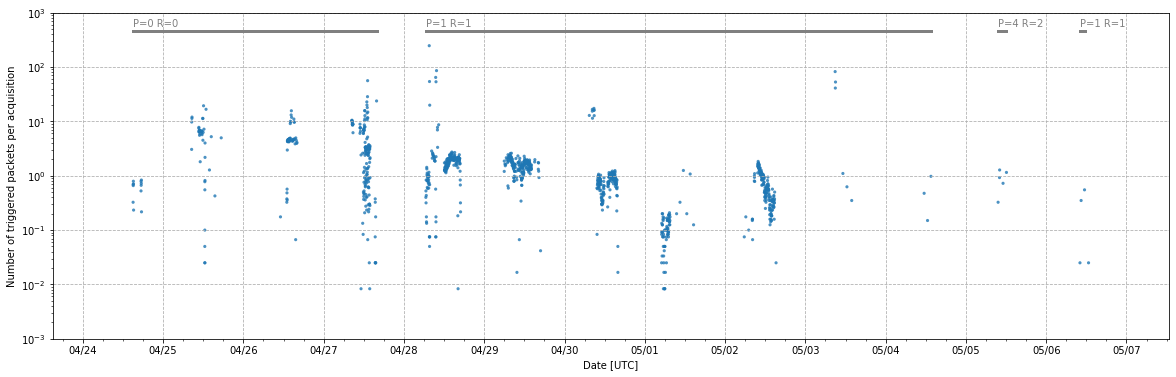

In [38]:
#vis_trigger_rate(otgpp_file_trigger_datetime_list, otgpp_file_trigger_rate_list, otgpp_file_trigger_p_r_list)
vis_trigger_rate(
    otgpp_file_trigger_datetime_list, otgpp_file_trigger_rate_list, otgpp_file_trigger_p_r_list,
    ylim=(10**(-2.5), 10**(2.5))
)

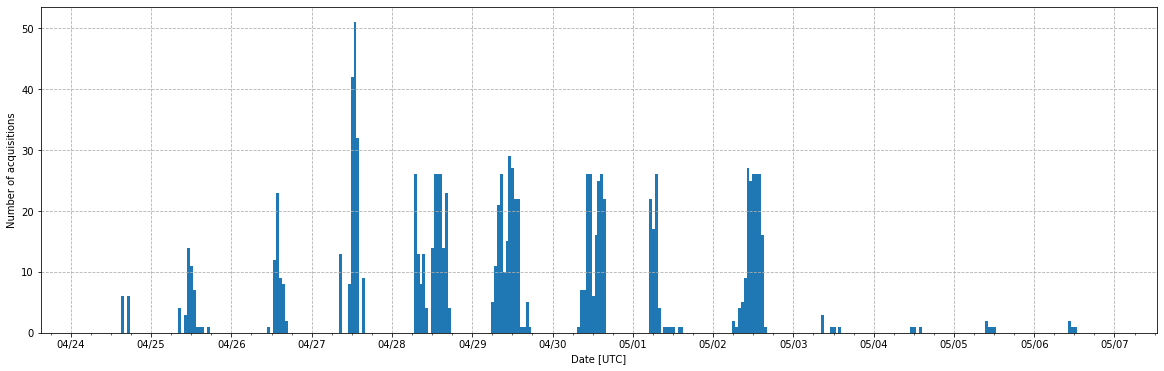

(<Figure size 1440x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feef745fe48>)

In [39]:
trigger_datetime_hist(otgpp_file_trigger_datetime_list)

In [40]:
# dir(physt)
# physt.plotting.backends['matplotlib'].types
# physt.plotting.backends['matplotlib'].dims

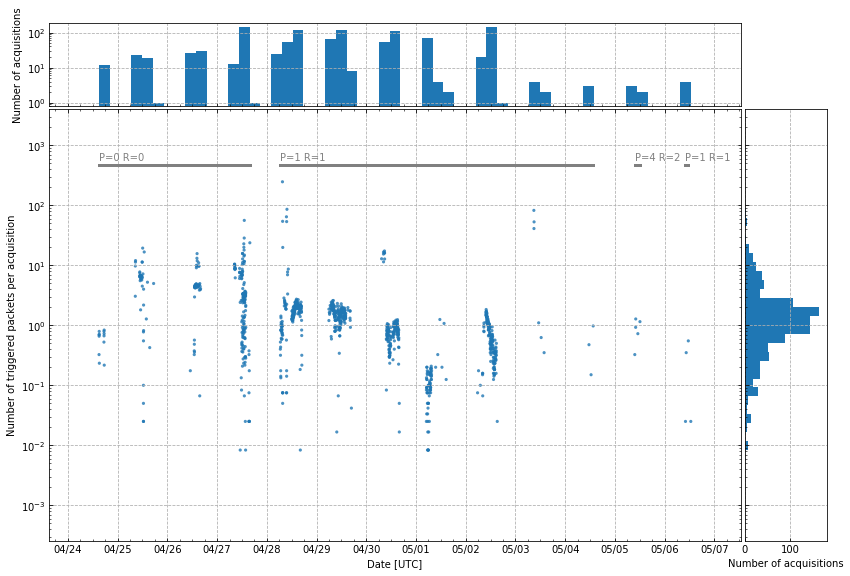

(<Figure size 864x576 with 3 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fef284e6f28>)

In [41]:
vis_trigger_rate_w_distributions(
    otgpp_file_trigger_datetime_list, otgpp_file_trigger_rate_list, otgpp_file_trigger_p_r_list
)